# Dataloading

In [15]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.wandb_utils import CRLRunCollector
from utils.create_zip import save_and_load
from utils.configs import Config

from qscaled.preprocessing import bootstrap_crossings
from qscaled.visualization import plot_per_batch_size, plot_per_lr
from qscaled.bootstrap_envsteps_to_thresh import (
    grid_best_uncertainty_lr,
    grid_best_uncertainty_bs,
    get_bootstrap_optimal,
    compute_bootstrap_averages,
    plot_bootstrap_average_params,
    linear_fit_separate,
    linear_fit_shared,
    tabulate_proposed_params,
    tabulate_baseline_params
)

np.random.seed(42)

To use this code:
1. Label your Wandb runs with tags.
2. Fill in `MyRunCollector` in `utils/wandb_utils.py`.
3. Update the following cell.

The latter two steps take ~5 minutes!

If you set `wandb_collect == True`, your `zip` file will be rebuilt using your
Wandb collector. Otherwise, the `zip` file must be present.

In [2]:
wandb_collect = False
name = 'gym_sweep'

if wandb_collect:
    wandb_collector = CRLRunCollector('prestonfu', 'crl').create(
        load=True,
        tags=['sac_grid_manual_250206'],
        path=f'../../cache/collector/{name}.npy',
        parallel=True
    )
    # Remove these lines if you'd like
    wandb_collector.remove_short(0.95)
    wandb_collector.trim(num_seeds=8, verbose=True)
else:
    wandb_collector = None

# Maximum possible returns (estimated with infinite data and compute) on each
# environment. These are mostly eyeballed such that runs reach 80% (hence
# the 1.25 multiplier) but not 90%. There is some variation for different environments.

config = Config(
    name=name,
    max_returns={
        "HalfCheetah-v4": 7300 * 1.25,
        "Walker2d-v4": 4000 * 1.25,
        "Ant-v4": 5300 * 1.25,
        "Humanoid-v4": 5200 * 1.25,
    },
    return_key='episode/return',
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16],
    wandb_collector=wandb_collector
)

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

If you used the code above with `save_loop`, use `UTDGroupedLoader` below.
(`FullGroupedLoaderUnlabeled` is used below for DMC data, which was collected independently.)

In [3]:
grid_search_df, (envs, utds, batch_sizes, learning_rates) = save_and_load(config)

grid_search_df = bootstrap_crossings(
    grid_search_df, 
    config.thresholds, 
    bootstrap_cache_file=f'../../cache/bootstrap_results/{name}.pkl'
)

Average standard deviation across all conditions: 2771.15


# Visualization

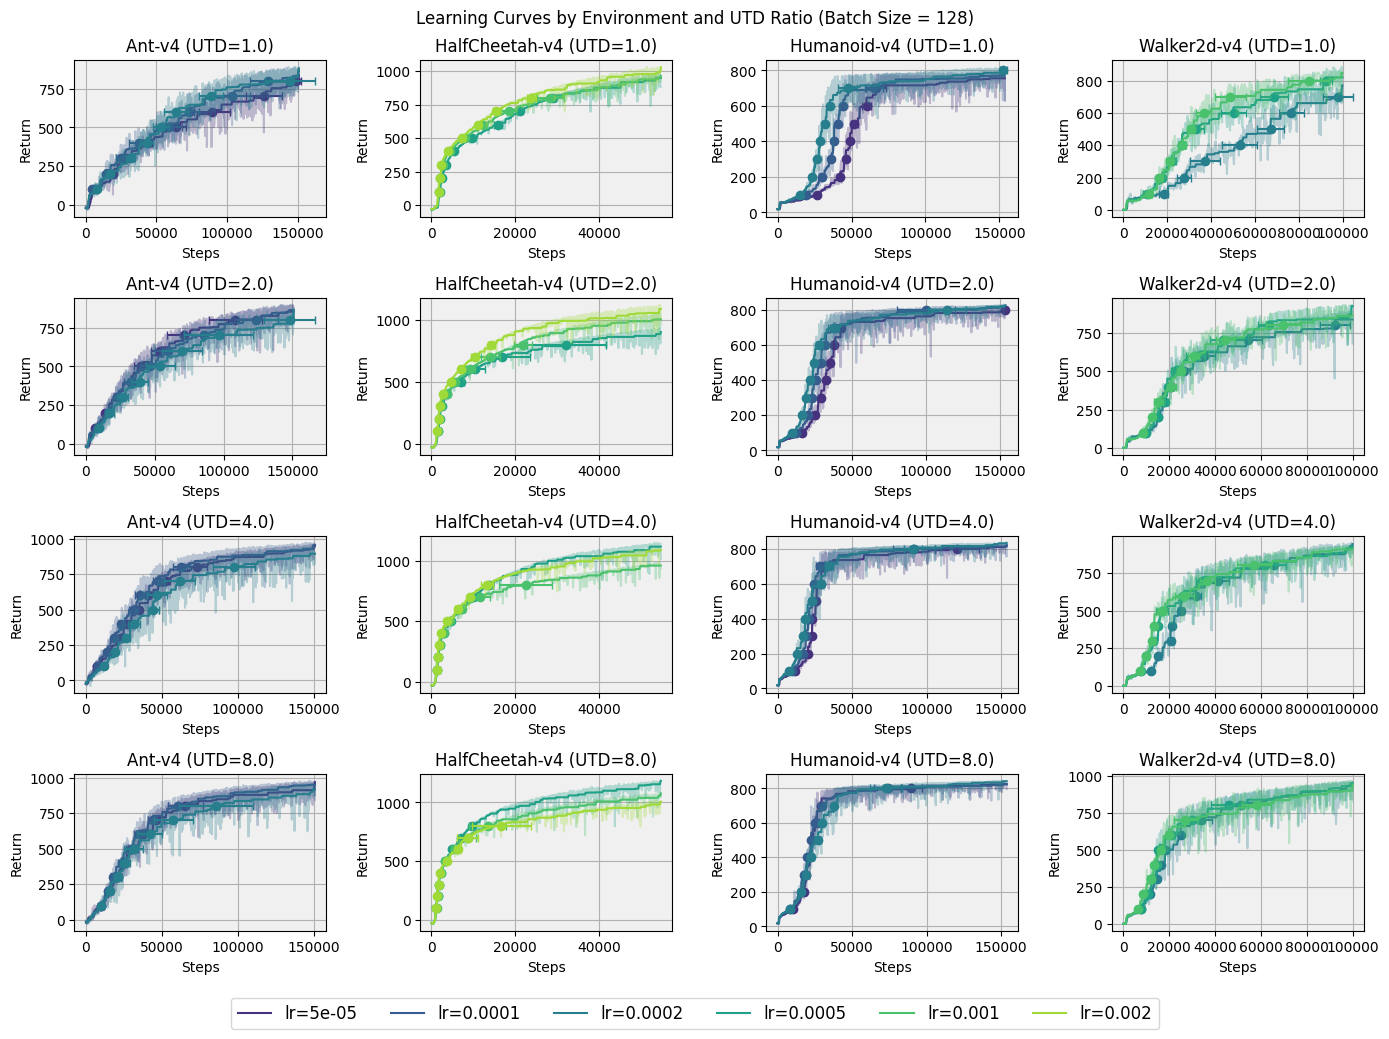

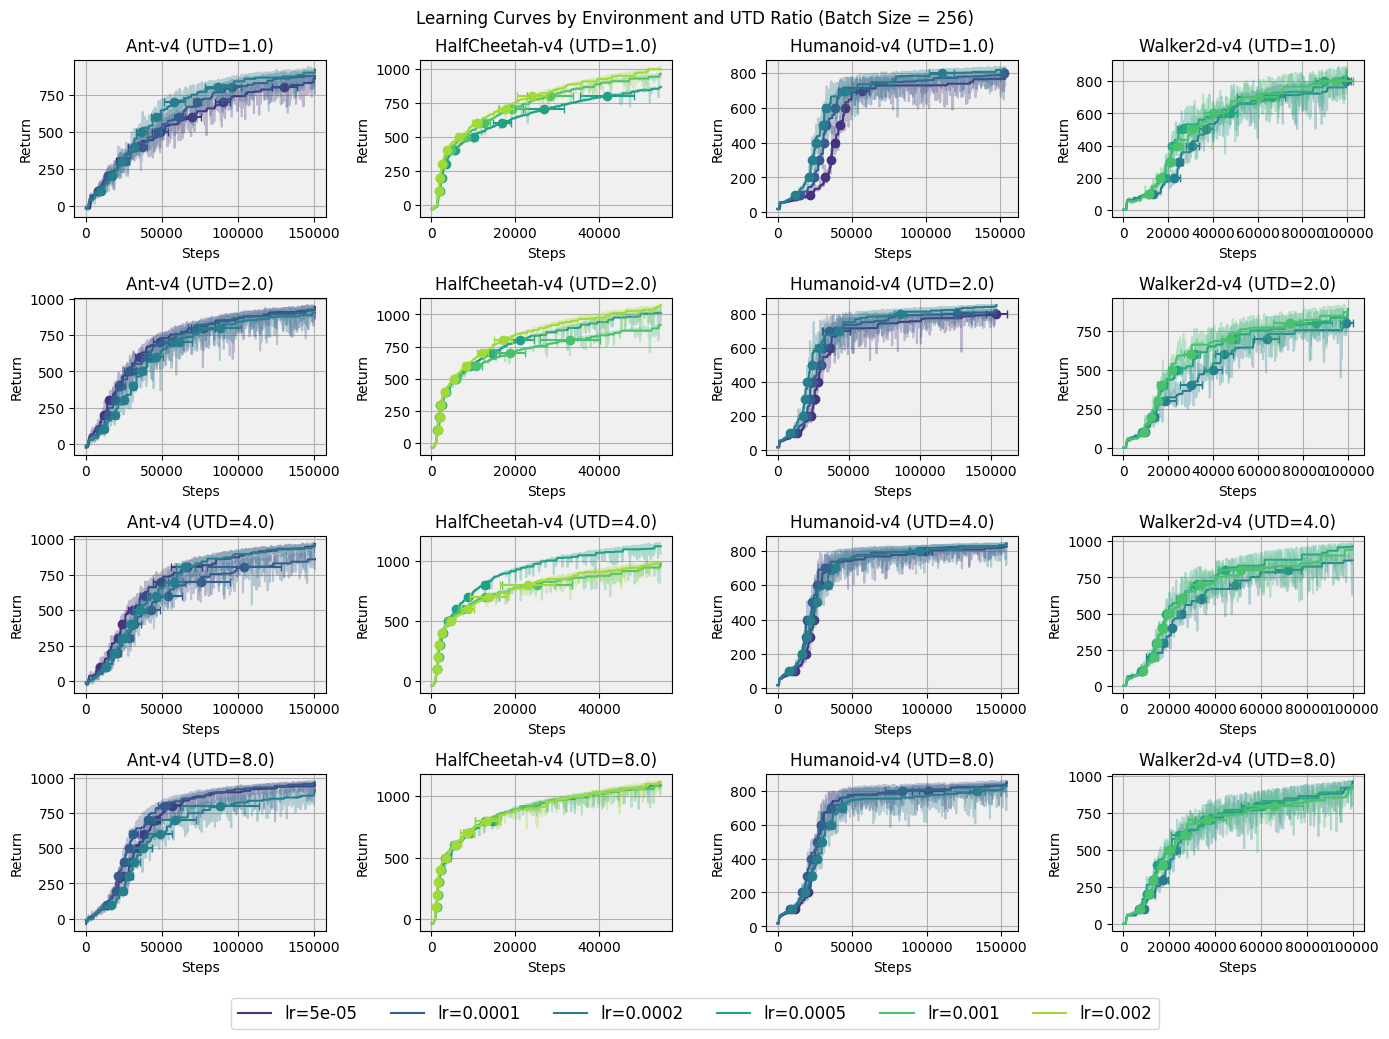

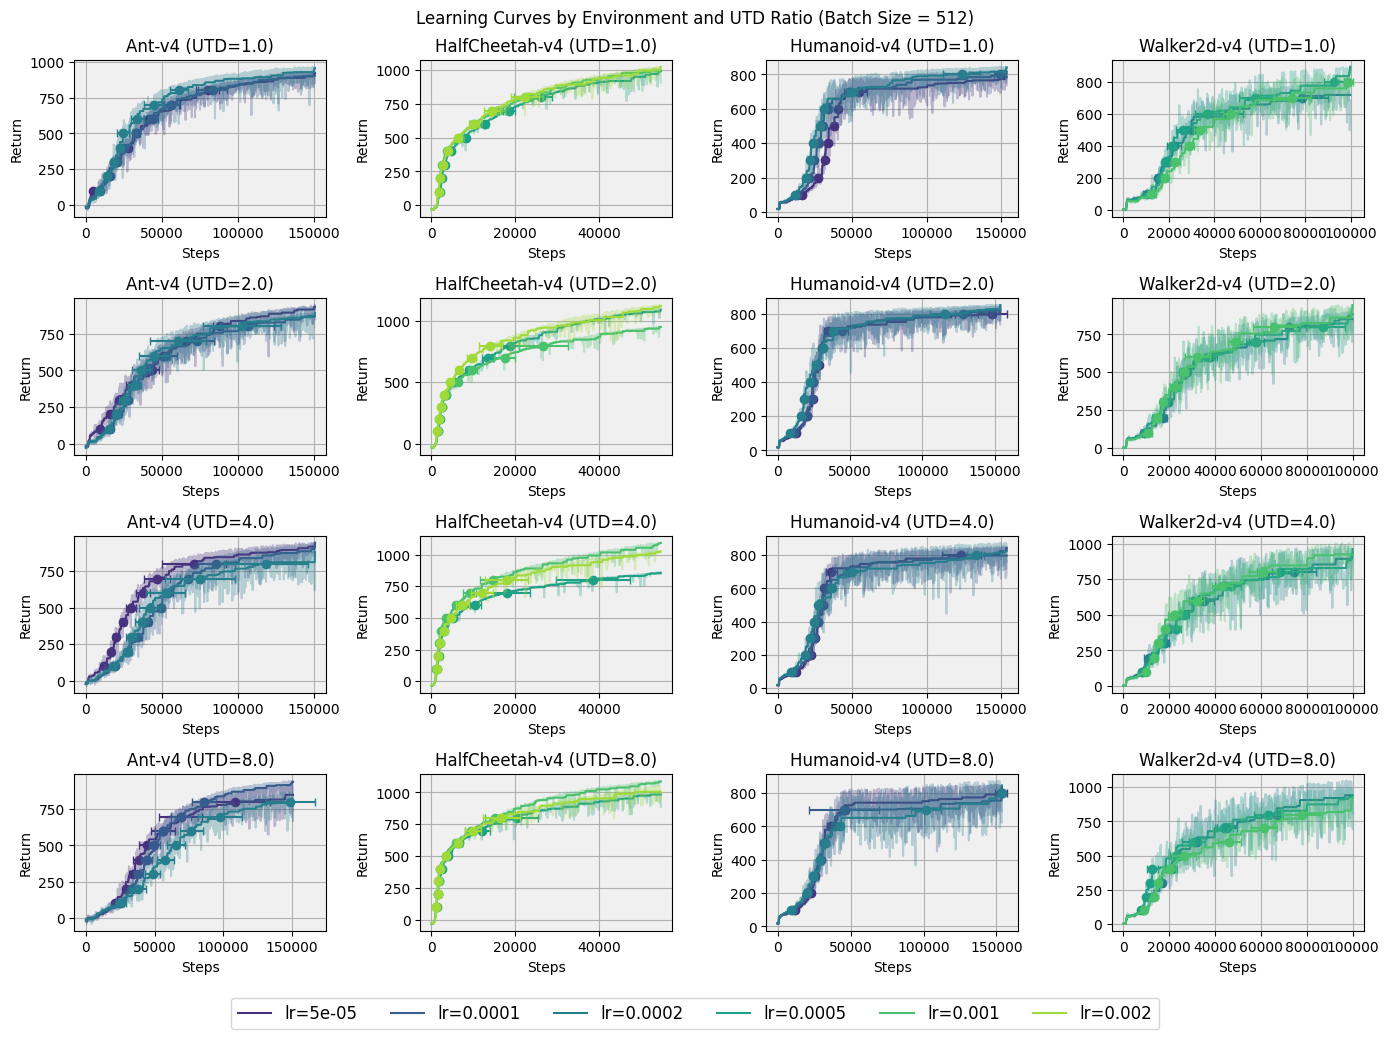

In [4]:
plot_per_batch_size(grid_search_df, len(utds), len(envs), batch_sizes, config.thresholds)

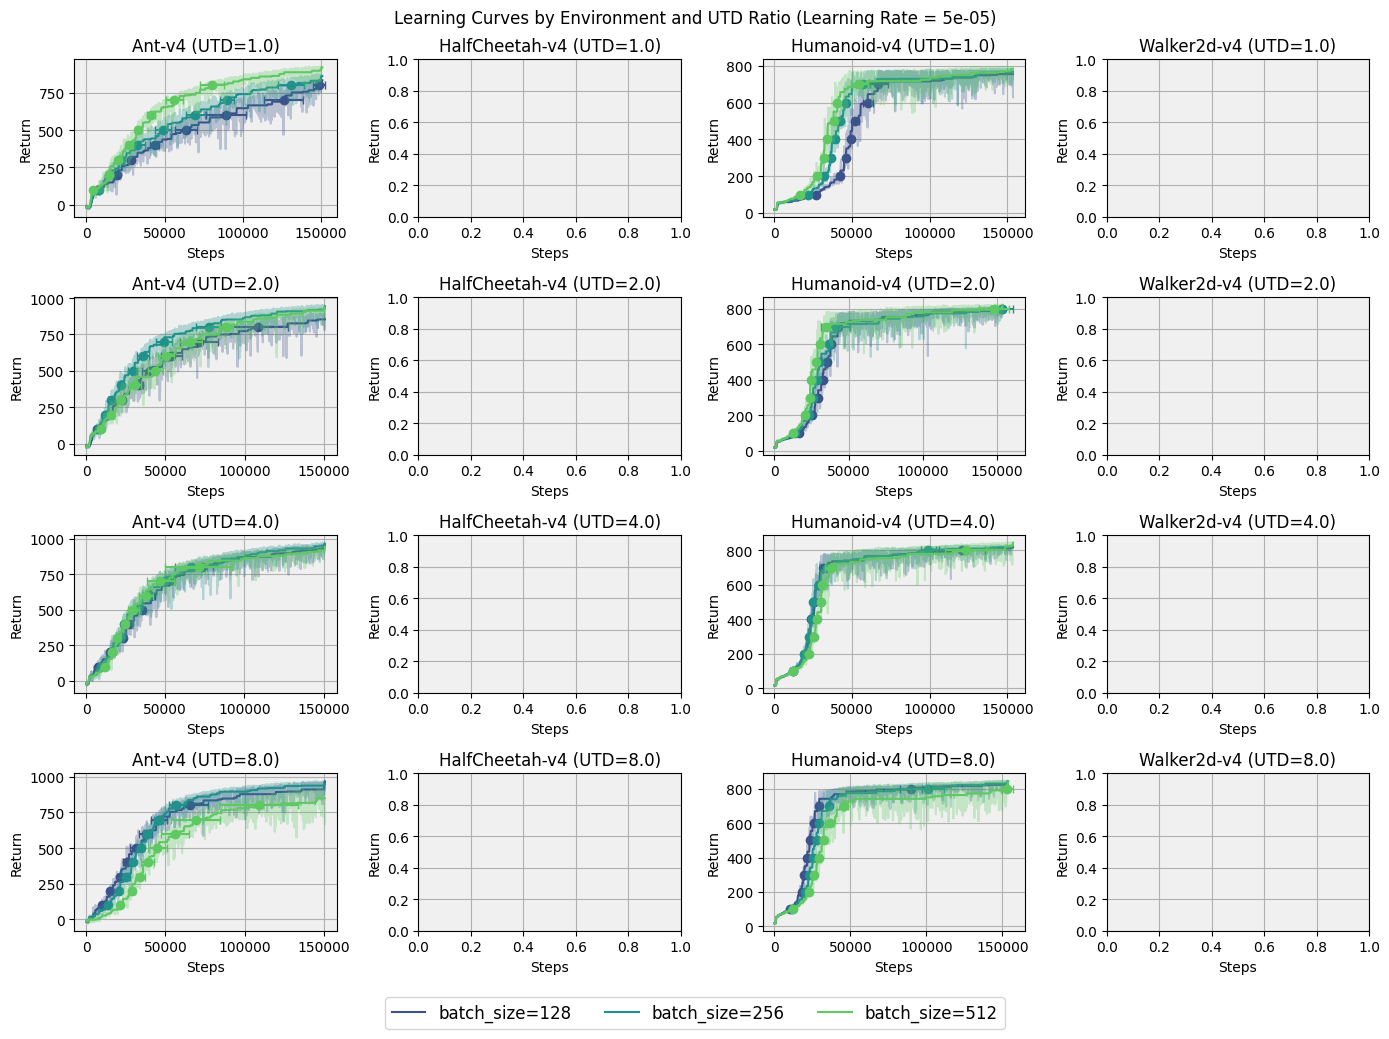

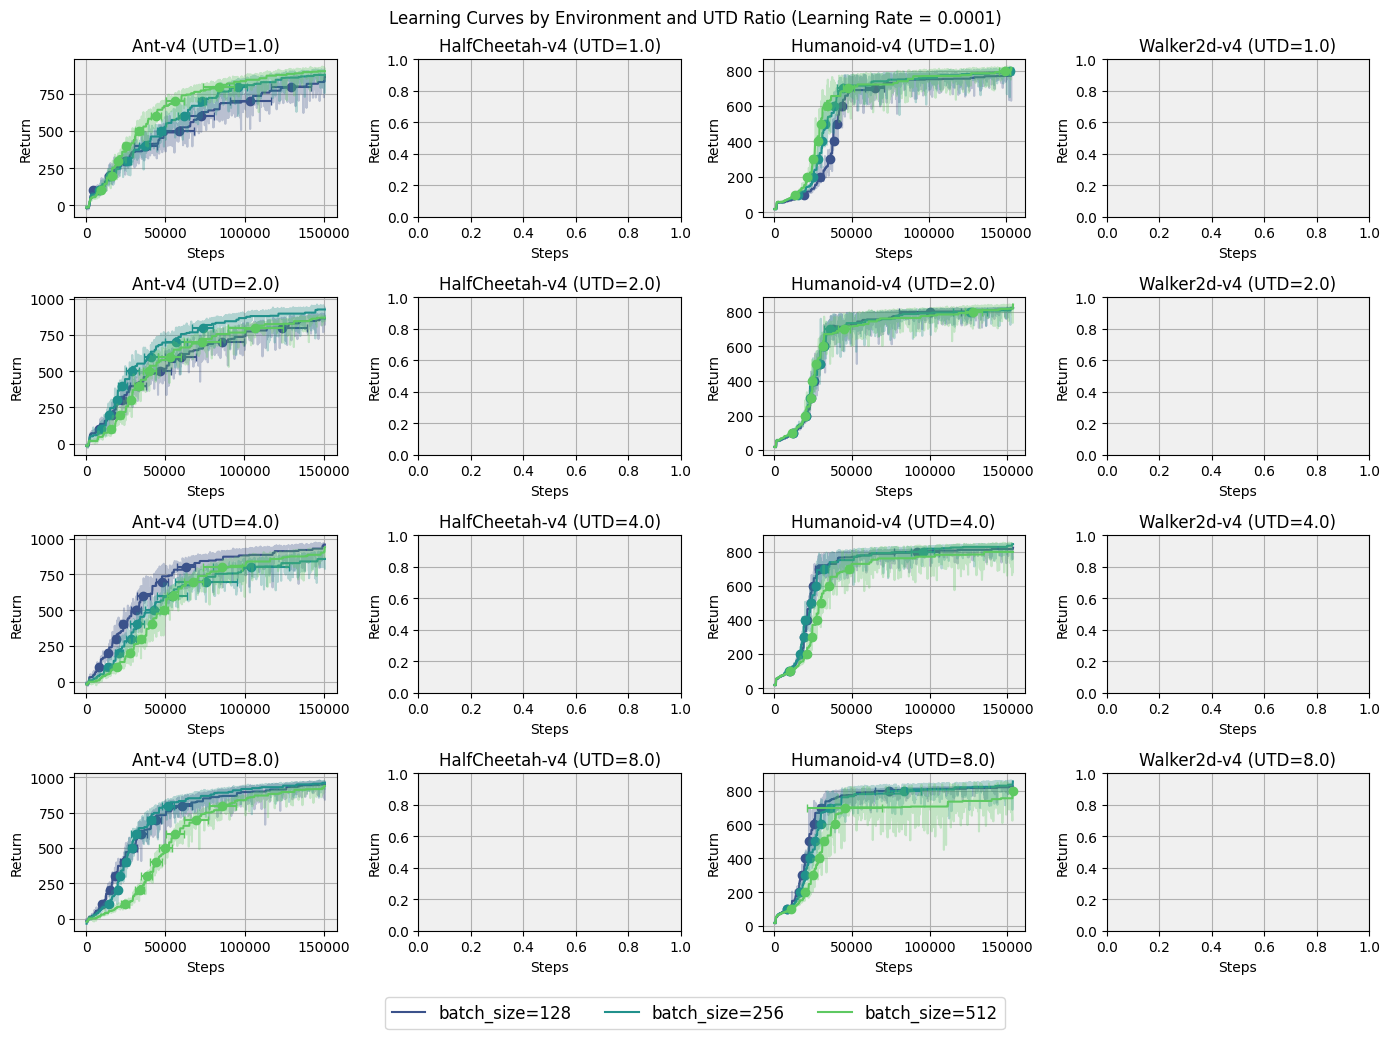

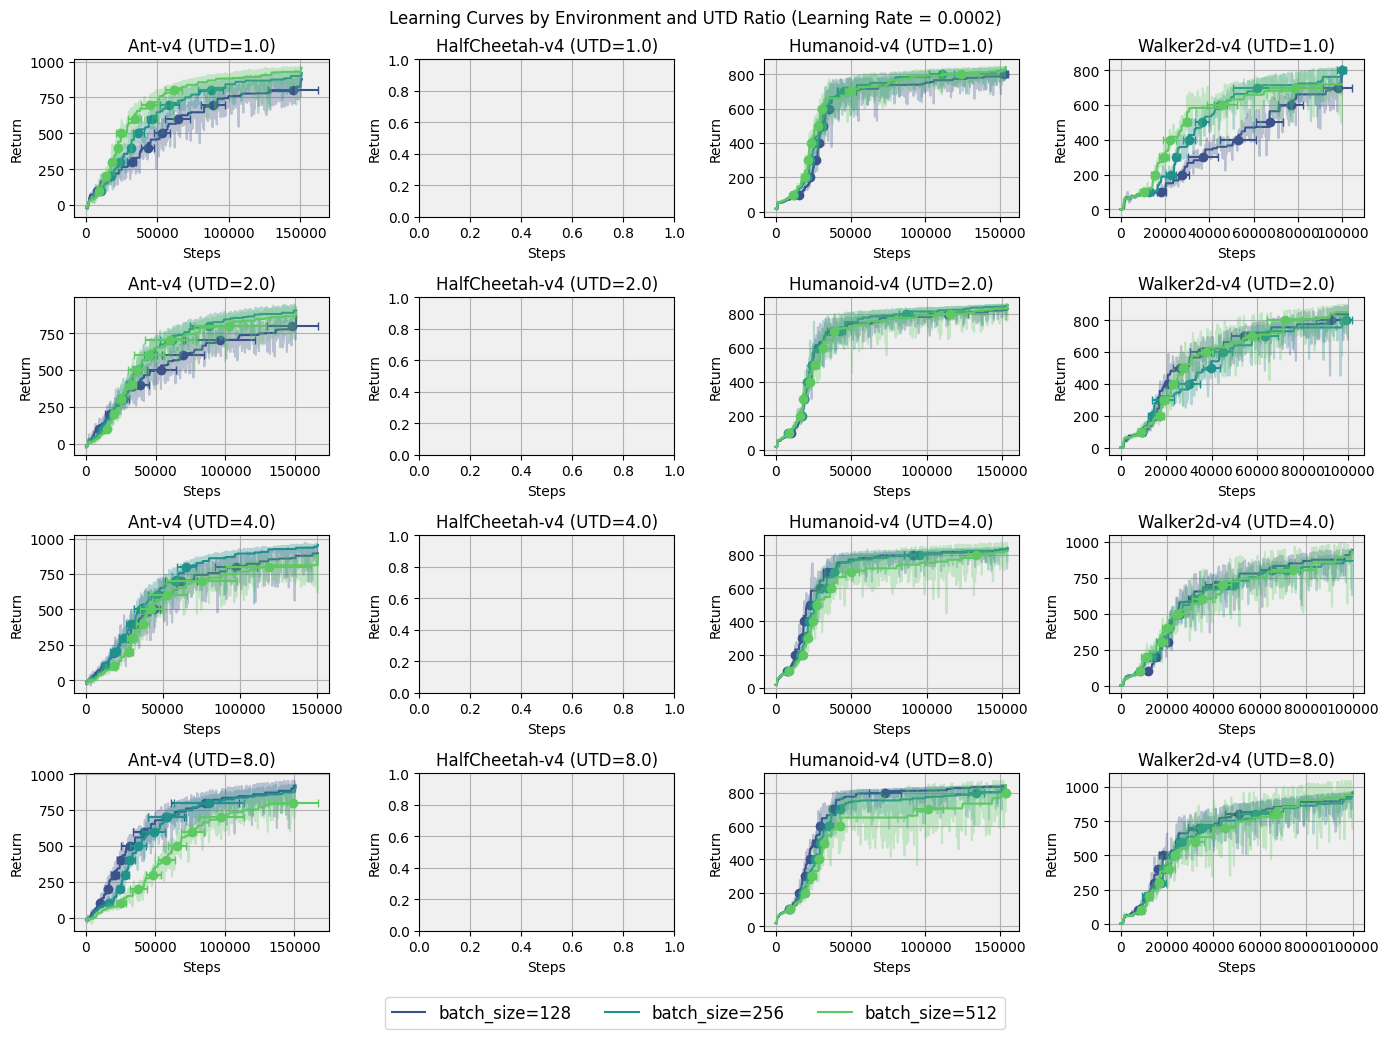

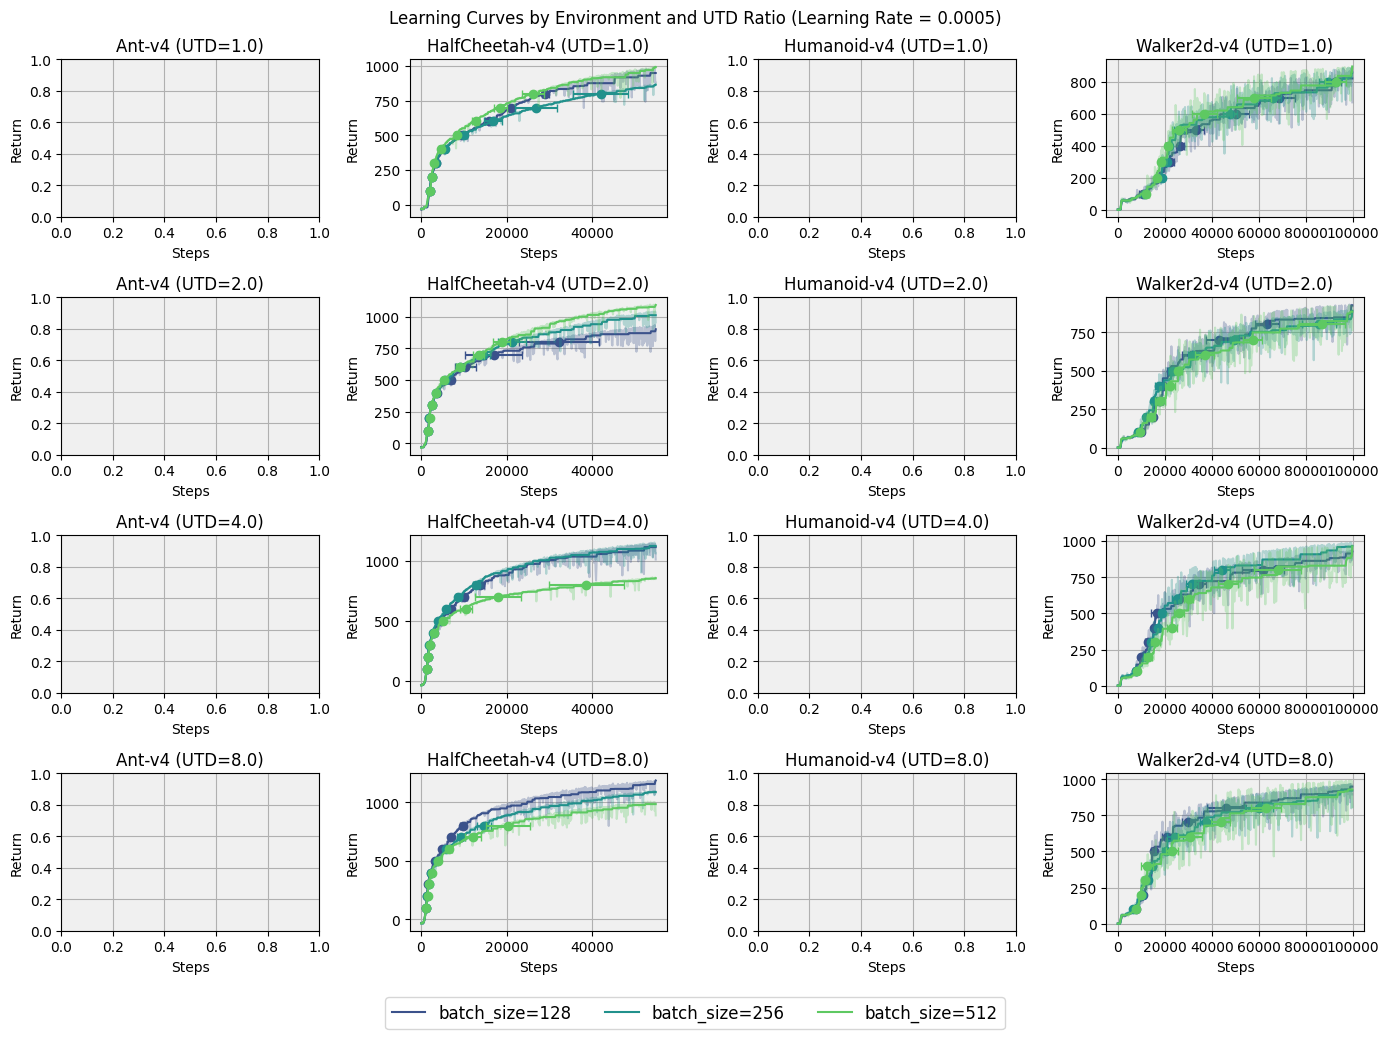

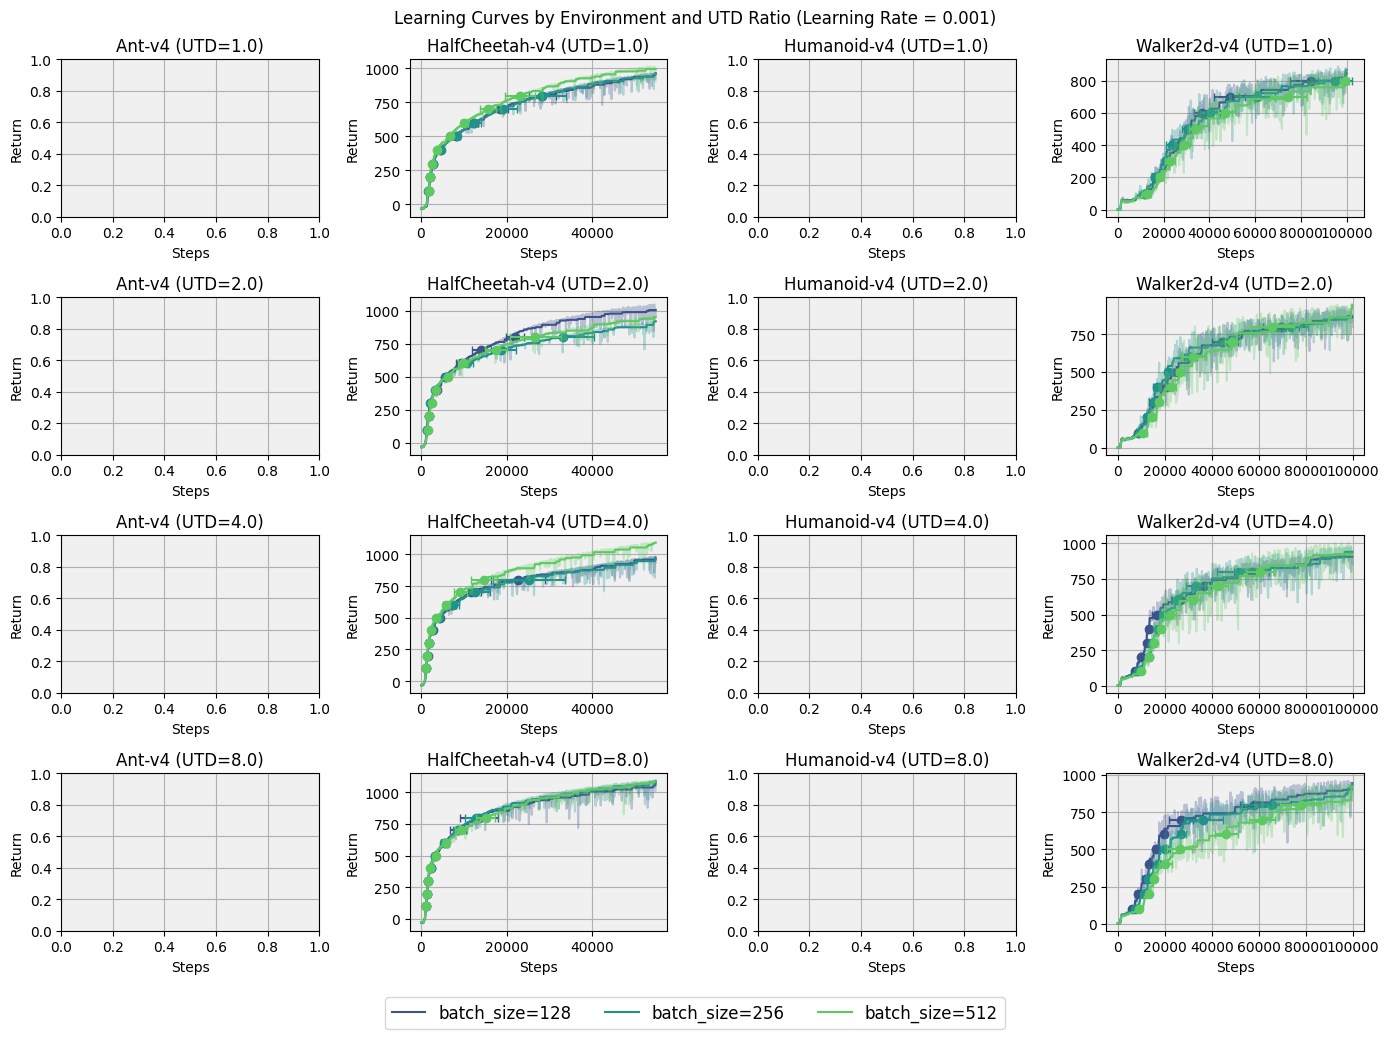

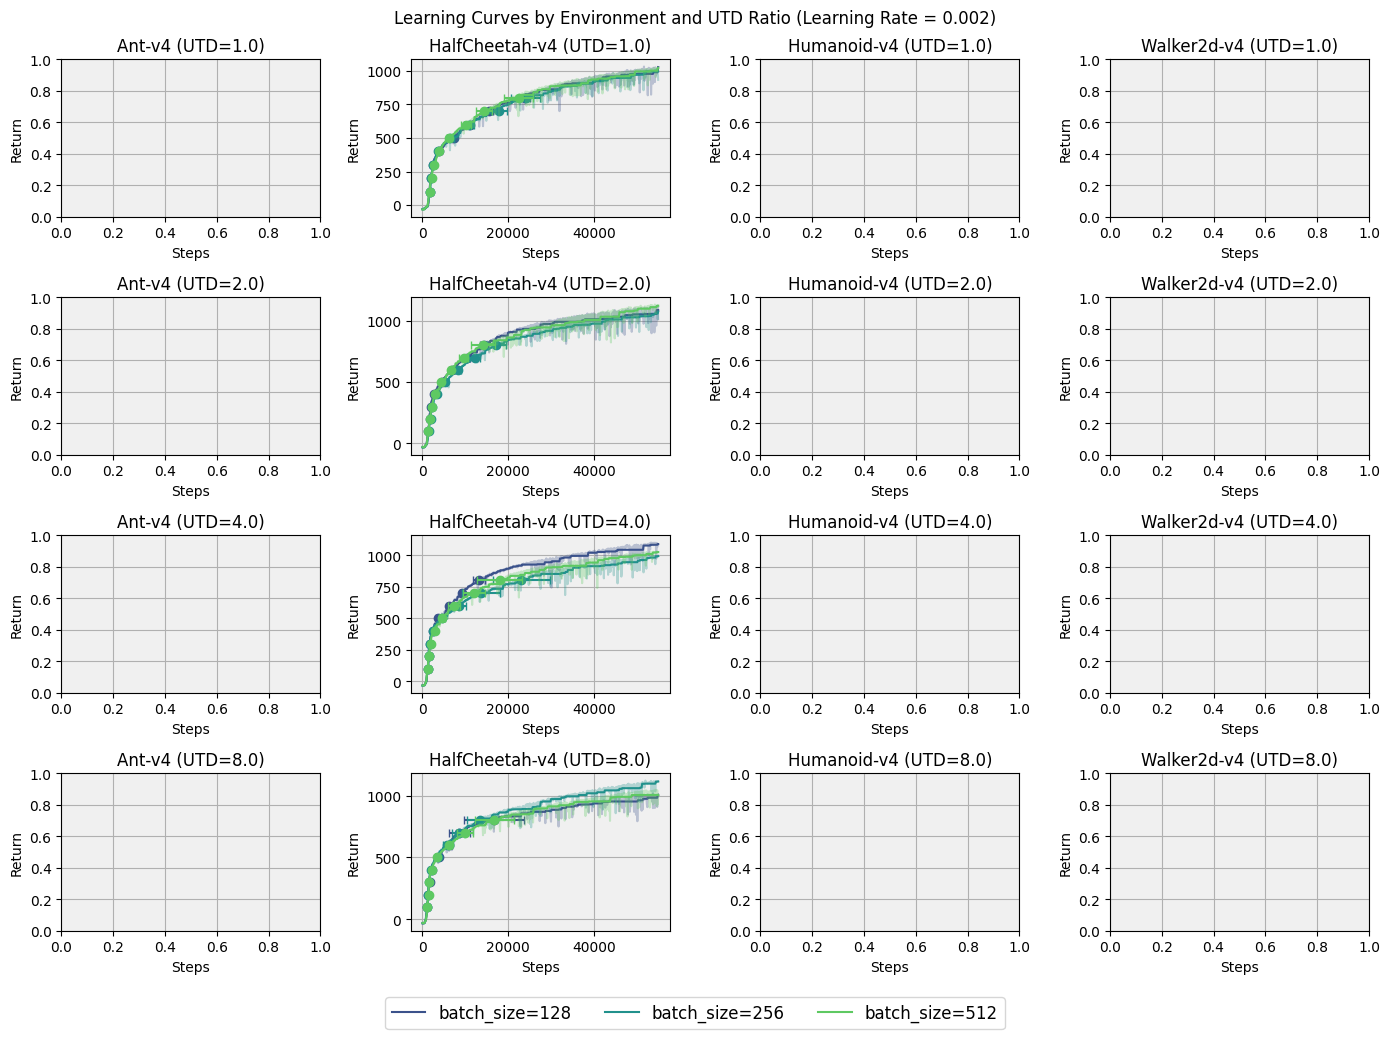

In [5]:
plot_per_lr(grid_search_df, len(utds), len(envs), learning_rates, config.thresholds)

# Bootstrapping

In [6]:
best_lr = grid_best_uncertainty_lr(grid_search_df, print_pivot=True)


Best Learning Rates:
env_name    Ant-v4                 HalfCheetah-v4                 Humanoid-v4                 Walker2d-v4                
batch_size     128     256     512            128     256     512         128     256     512         128     256     512
utd                                                                                                                      
1.0e+00    1.0e-04 2.0e-04 2.0e-04        2.0e-03 2.0e-03 2.0e-03     2.0e-04 2.0e-04 2.0e-04     1.0e-03 5.0e-04 5.0e-04
2.0e+00    5.0e-05 1.0e-04 5.0e-05        2.0e-03 2.0e-03 2.0e-03     1.0e-04 2.0e-04 2.0e-04     5.0e-04 1.0e-03 1.0e-03
4.0e+00    1.0e-04 2.0e-04 5.0e-05        2.0e-03 5.0e-04 1.0e-03     2.0e-04 2.0e-04 5.0e-05     1.0e-03 5.0e-04 1.0e-03
8.0e+00    1.0e-04 1.0e-04 1.0e-04        5.0e-04 1.0e-03 1.0e-03     2.0e-04 1.0e-04 5.0e-05     5.0e-04 2.0e-04 5.0e-04

Uncertainty-Corrected Best Learning Rates:
env_name    Ant-v4                 HalfCheetah-v4                 Humanoid-v4   

In [7]:
best_bs = grid_best_uncertainty_bs(grid_search_df, print_pivot=True)


Best Batch Sizes:
env_name       Ant-v4                 HalfCheetah-v4                 Humanoid-v4                 Walker2d-v4                
learning_rate 5.0e-05 1.0e-04 2.0e-04        5.0e-04 1.0e-03 2.0e-03     5.0e-05 1.0e-04 2.0e-04     2.0e-04 5.0e-04 1.0e-03
utd                                                                                                                         
1.0e+00       5.1e+02 5.1e+02 5.1e+02        5.1e+02 5.1e+02 5.1e+02         NaN 5.1e+02 2.6e+02     2.6e+02 2.6e+02 1.3e+02
2.0e+00       2.6e+02 2.6e+02 2.6e+02        5.1e+02 1.3e+02 5.1e+02     5.1e+02 1.3e+02 2.6e+02     5.1e+02 1.3e+02 5.1e+02
4.0e+00       2.6e+02 1.3e+02 2.6e+02        2.6e+02 5.1e+02 1.3e+02     2.6e+02 1.3e+02 1.3e+02     1.3e+02 2.6e+02 2.6e+02
8.0e+00       2.6e+02 2.6e+02 1.3e+02        1.3e+02 2.6e+02 2.6e+02     1.3e+02 1.3e+02 1.3e+02     1.3e+02 1.3e+02 1.3e+02

Uncertainty-Corrected Best Batch Sizes:
env_name       Ant-v4                 HalfCheetah-v4             

/home/preston/value-scaling-workflow-private/qscaled/bootstrap_envsteps_to_thresh.py:139: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_bs = group.loc[group['last_crossing'].idxmin(skipna=True), 'batch_size']


In [8]:
best_lr_bs = best_lr.groupby(['env_name', 'utd']).apply(get_bootstrap_optimal, include_groups=False).reset_index()
best_lr_bs = compute_bootstrap_averages(best_lr, best_bs, best_lr_bs)
best_lr_bs

env_name     utd  best_lr  best_bs  time_to_threshold  \
0           Ant-v4 1.0e+00  2.0e-04      512            6.1e+04   
1           Ant-v4 2.0e+00  1.0e-04      256            7.4e+04   
2           Ant-v4 4.0e+00  1.0e-04      128            6.3e+04   
3           Ant-v4 8.0e+00  1.0e-04      256            5.1e+04   
4   HalfCheetah-v4 1.0e+00  2.0e-03      512            2.2e+04   
5   HalfCheetah-v4 2.0e+00  2.0e-03      512            1.4e+04   
6   HalfCheetah-v4 4.0e+00  5.0e-04      256            1.3e+04   
7   HalfCheetah-v4 8.0e+00  5.0e-04      128            9.8e+03   
8      Humanoid-v4 1.0e+00  2.0e-04      256            1.1e+05   
9      Humanoid-v4 2.0e+00  2.0e-04      256            8.6e+04   
10     Humanoid-v4 4.0e+00  2.0e-04      128            9.1e+04   
11     Humanoid-v4 8.0e+00  2.0e-04      128            7.3e+04   
12     Walker2d-v4 1.0e+00  1.0e-03      128            8.4e+04   
13     Walker2d-v4 2.0e+00  5.0e-04      128            6.4e+04   
14     Walker2d-v4 4.0e+00  5.0e-04      256            4.4e+04   
15     Walker2d-v4 8.0e+00  5.0e-04      128            4.6e+04   

                                    best_lr_bootstrap  \
0   [0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...   
1   [5e-05, 0.0002, 0.0002, 5e-05, 5e-05, 0.0002, ...   
2   [0.0002, 5e-05, 0.0001, 0.0002, 0.0001, 0.0001...   
3   [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.000...   
4   [0.001, 0.001, 0.002, 0.001, 0.002, 0.002, 0.0...   
5   [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0...   
6   [0.0005, 0.002, 0.0005, 0.001, 0.0005, 0.0005,...   
7   [0.0005, 0.001, 0.0005, 0.0005, 0.0005, 0.0005...   
8   [0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...   
9   [0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...   
10  [0.0001, 0.0002, 0.0001, 0.0002, 0.0001, 0.000...   
11  [5e-05, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002...   
12  [0.0005, 0.0005, 0.0005, 0.001, 0.0005, 0.0005...   
13  [0.0005, 0.0005, 0.0005, 0.0005, 0.001, 0.0005...   
14  [0.0005, 0.0005, 0.001, 0.0005, 0.0005, 0.0005...   
15  [0.0002, 0.0002, 0.0005, 0.0005, 0.0002, 0.000...   

                                    best_bs_bootstrap  \
0   [512, 512, 512, 512, 512, 512, 512, 512, 512, ...   
1   [256, 256, 512, 256, 256, 256, 256, 256, 256, ...   
2   [256, 256, 128, 256, 128, 128, 512, 512, 512, ...   
3   [256, 256, 256, 256, 256, 256, 256, 256, 256, ...   
4   [512, 512, 512, 512, 512, 128, 256, 512, 512, ...   
5   [512, 512, 512, 512, 256, 512, 512, 512, 128, ...   
6   [128, 128, 256, 512, 256, 256, 256, 256, 512, ...   
7   [128, 128, 128, 128, 128, 128, 128, 128, 128, ...   
8   [512, 256, 256, 512, 256, 256, 256, 256, 256, ...   
9   [256, 256, 256, 256, 256, 256, 256, 256, 256, ...   
10  [256, 128, 128, 128, 256, 128, 128, 128, 128, ...   
11  [256, 128, 128, 128, 128, 128, 128, 128, 128, ...   
12  [128, 512, 512, 128, 256, 128, 256, 128, 128, ...   
13  [128, 512, 128, 128, 128, 128, 512, 512, 128, ...   
14  [256, 128, 256, 256, 256, 256, 256, 256, 256, ...   
15  [128, 128, 128, 128, 128, 256, 128, 128, 128, ...   

                          time_to_threshold_bootstrap  best_bs_bootstrap_mean  \
0   [51622.79245283019, 67169.96226415093, 73358.6...                 5.1e+02   
1   [63547.32075471698, 61434.11320754717, 68226.5...                 3.0e+02   
2   [63698.11320754717, 66264.30188679245, 55396.3...                 3.0e+02   
3   [53283.16981132075, 46037.88679245283, 49660.5...                 2.4e+02   
4   [20821.917808219176, 20054.794520547945, 17972...                 4.1e+02   
5   [13479.45205479452, 12383.561643835616, 11506....                 3.3e+02   
6   [12712.328767123287, 12054.794520547945, 11068...                 2.5e+02   
7   [10958.90410958904, 8986.301369863013, 10301.3...                 1.3e+02   
8   [123538.61538461539, 110461.69230769231, 11046...                 3.5e+02   
9   [80461.69230769231, 86154.0, 84307.84615384616...                 2.5e+02   
10  [73384.76923076923, 92154.0, 78000.

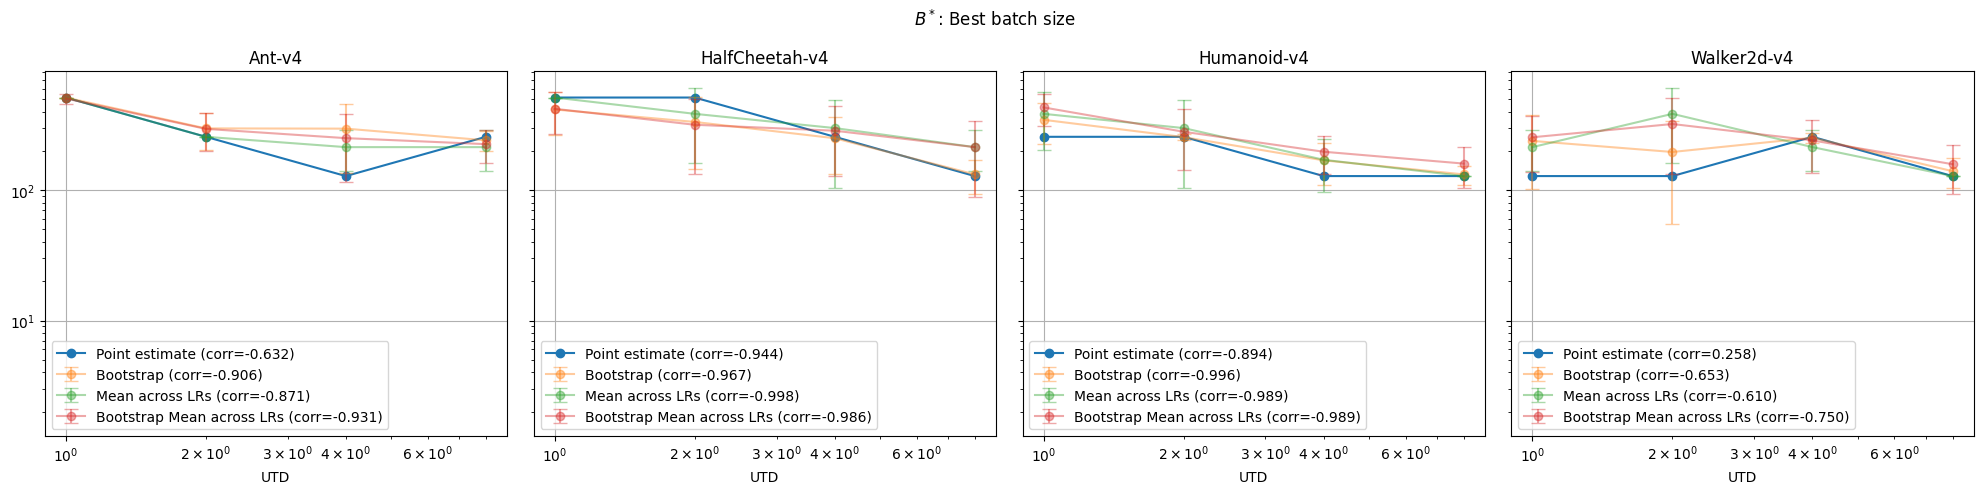

/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


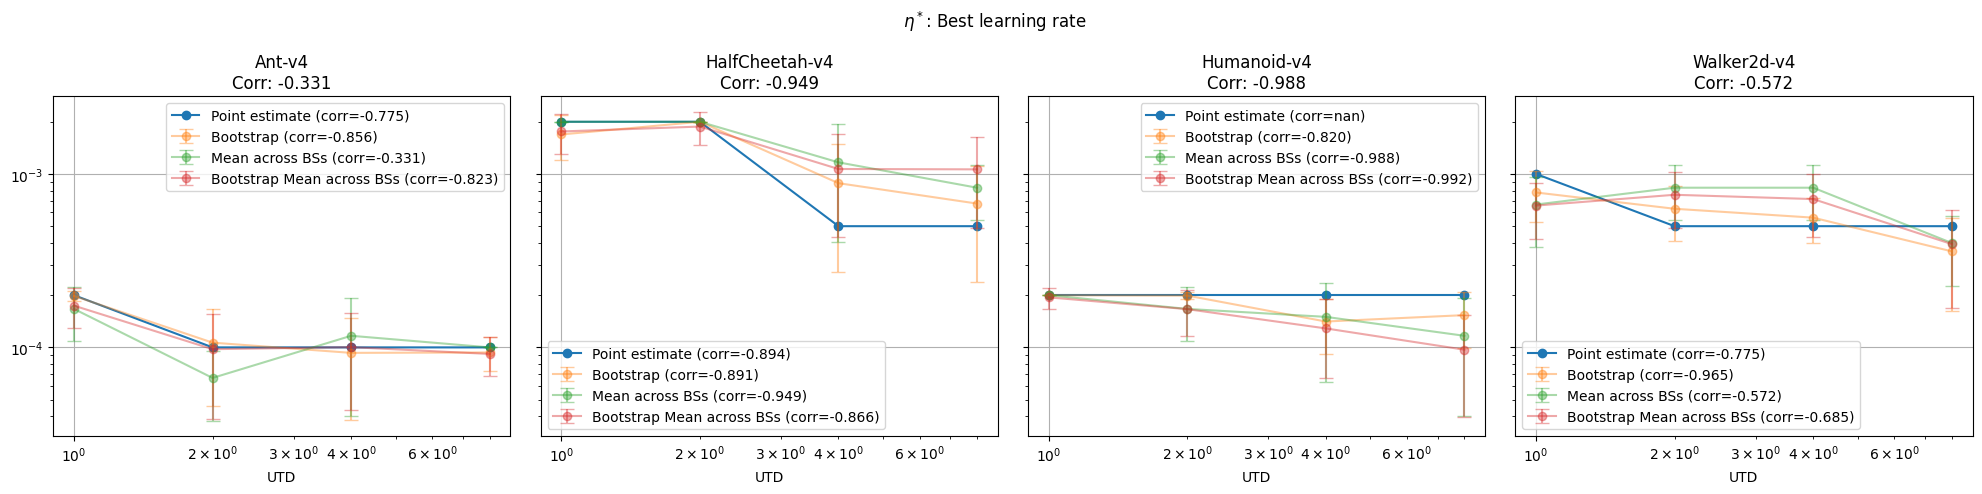

In [9]:
plot_bootstrap_average_params(best_lr_bs)

Ant-v4: lr ~ 473.104576 * UTD^-0.504907
HalfCheetah-v4: lr ~ 407.620973 * UTD^-0.279405
Humanoid-v4: lr ~ 424.610064 * UTD^-0.564328
Walker2d-v4: lr ~ 277.017624 * UTD^-0.039877


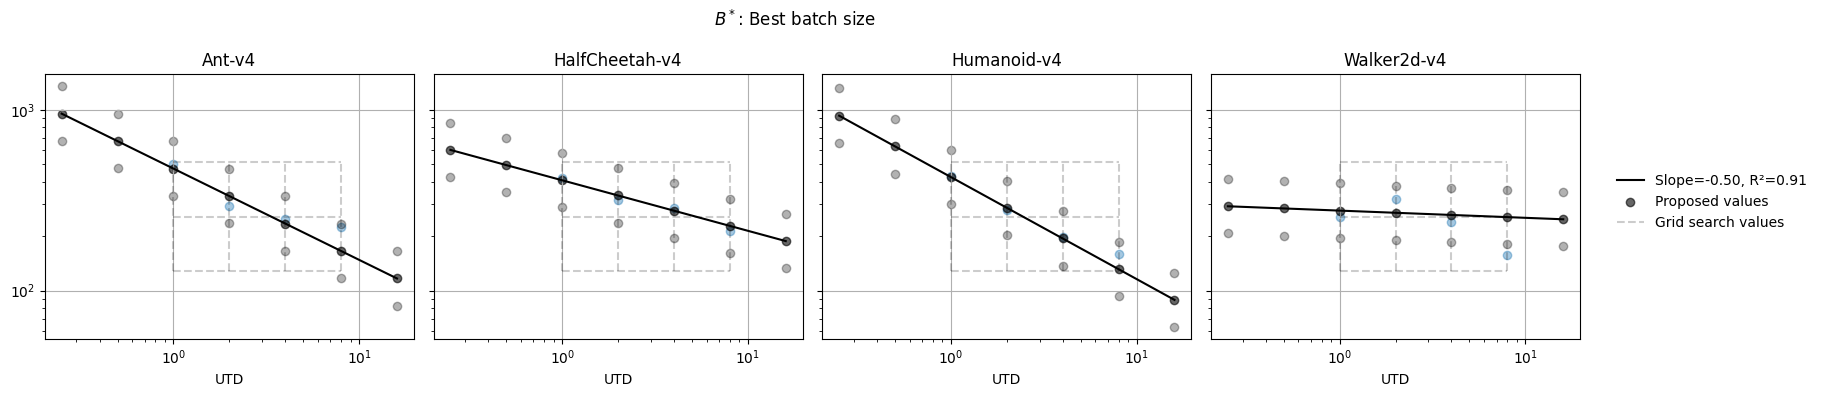

Ant-v4: bs ~ 0.000157 * UTD^-0.397143
HalfCheetah-v4: bs ~ 0.001953 * UTD^-0.359423
Humanoid-v4: bs ~ 0.000198 * UTD^-0.297448
Walker2d-v4: bs ~ 0.000680 * UTD^0.062339


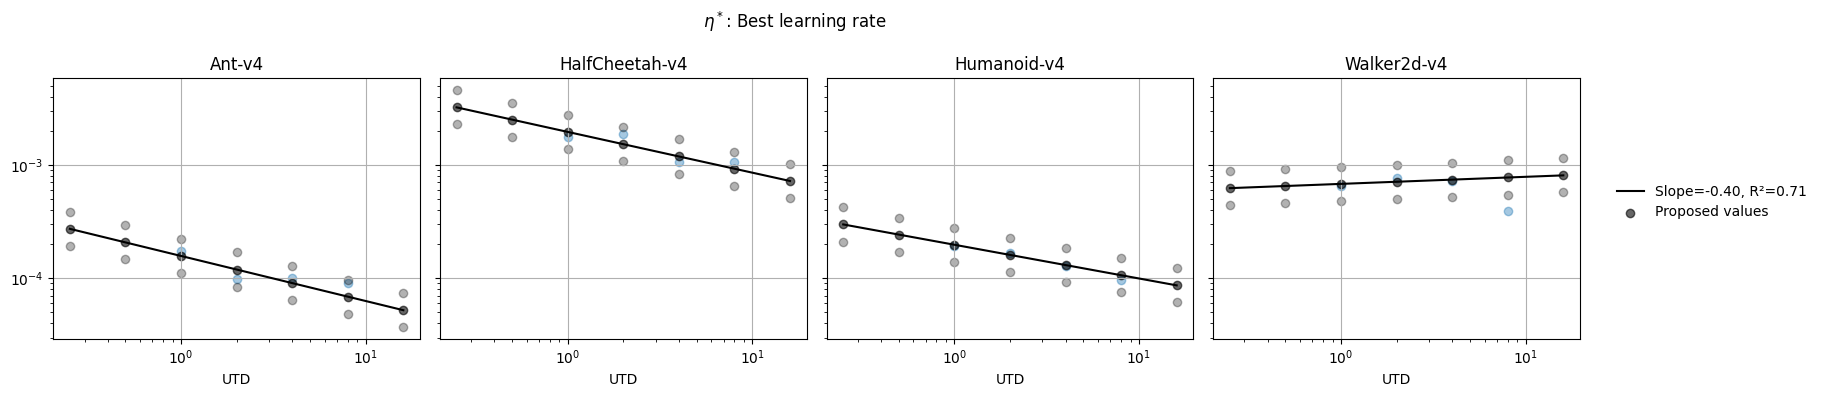

In [10]:
(
    proposed_lr_values_separate,
    proposed_bs_values_separate,
    lr_slopes_separate,
    lr_intercepts_separate,
    bs_slopes_separate,
    bs_intercepts_separate
) = linear_fit_separate(config.utds_to_predict, grid_search_df, best_lr_bs, plot=True)

Ant-v4: lr ~ 0.000150 * UTD^-0.284872
HalfCheetah-v4: lr ~ 0.001871 * UTD^-0.284872
Humanoid-v4: lr ~ 0.000191 * UTD^-0.284872
Walker2d-v4: lr ~ 0.000824 * UTD^-0.284872


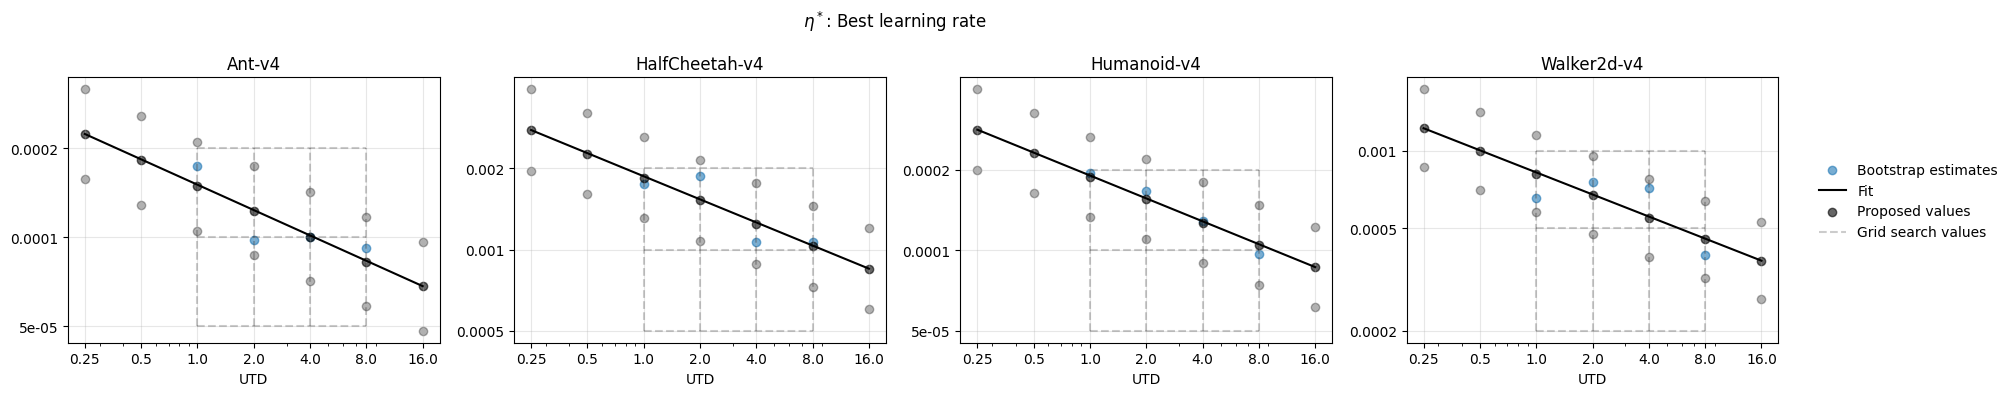

Ant-v4: batch size ~ 435.654339 * UTD^-0.351999
HalfCheetah-v4: batch size ~ 432.333192 * UTD^-0.351999
Humanoid-v4: batch size ~ 357.492090 * UTD^-0.351999
Walker2d-v4: batch size ~ 339.933091 * UTD^-0.351999


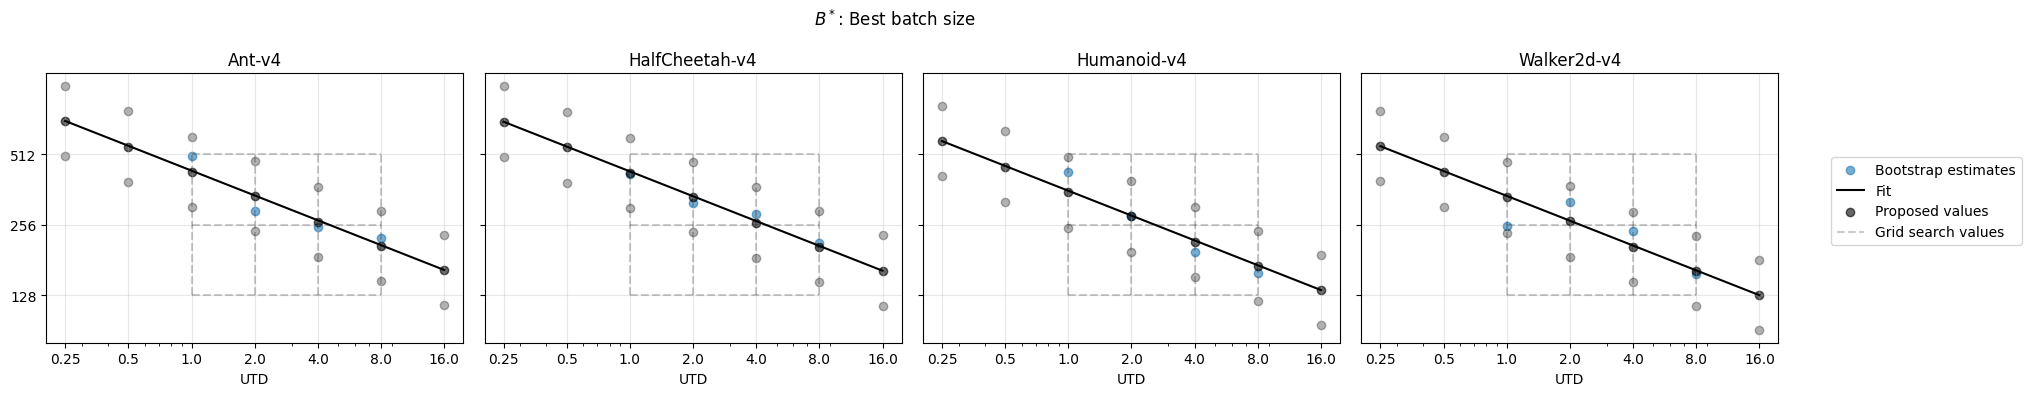

In [11]:
(
    proposed_lr_values,
    proposed_bs_values,
    lr_shared_slope,
    lr_env_intercepts,
    bs_shared_slope,
    bs_env_intercepts,
) = linear_fit_shared(config.utds_to_predict, grid_search_df, best_lr_bs, envs, name, plot=True)

In [12]:
pd.options.display.float_format = '{:.2e}'.format
proposed_values_df = tabulate_proposed_params(envs, config.utds_to_predict, proposed_lr_values, proposed_bs_values, name)
baseline_values_df = tabulate_baseline_params(grid_search_df, utds, config.utds_to_predict, len(envs), name)

Baseline based on UTD 2.0


/home/preston/value-scaling-workflow-private/qscaled/bootstrap_envsteps_to_thresh.py:1038: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utd_data['last_crossing'] = utd_data['crossings'].apply(lambda x: x[-1])


In [13]:
proposed_values_df

Environment      UTD  Learning Rate  Learning Rate x√2  \
0           Ant-v4 2.50e-01       2.23e-04           3.16e-04   
1           Ant-v4 5.00e-01       1.82e-04           2.58e-04   
2           Ant-v4 1.00e+00       1.49e-04           2.10e-04   
3           Ant-v4 2.00e+00       1.23e-04           1.73e-04   
4           Ant-v4 4.00e+00       1.00e-04           1.42e-04   
5           Ant-v4 8.00e+00       8.27e-05           1.17e-04   
6           Ant-v4 1.60e+01       6.82e-05           9.65e-05   
7   HalfCheetah-v4 2.50e-01       2.78e-03           3.93e-03   
8   HalfCheetah-v4 5.00e-01       2.27e-03           3.20e-03   
9   HalfCheetah-v4 1.00e+00       1.85e-03           2.61e-03   
10  HalfCheetah-v4 2.00e+00       1.53e-03           2.16e-03   
11  HalfCheetah-v4 4.00e+00       1.25e-03           1.76e-03   
12  HalfCheetah-v4 8.00e+00       1.03e-03           1.45e-03   
13  HalfCheetah-v4 1.60e+01       8.49e-04           1.20e-03   
14     Humanoid-v4 2.50e-01       2.83e-04           4.00e-04   
15     Humanoid-v4 5.00e-01       2.31e-04           3.26e-04   
16     Humanoid-v4 1.00e+00       1.88e-04           2.66e-04   
17     Humanoid-v4 2.00e+00       1.55e-04           2.20e-04   
18     Humanoid-v4 4.00e+00       1.27e-04           1.79e-04   
19     Humanoid-v4 8.00e+00       1.05e-04           1.48e-04   
20     Humanoid-v4 1.60e+01       8.65e-05           1.22e-04   
21     Walker2d-v4 2.50e-01       1.22e-03           1.73e-03   
22     Walker2d-v4 5.00e-01       9.98e-04           1.41e-03   
23     Walker2d-v4 1.00e+00       8.14e-04           1.15e-03   
24     Walker2d-v4 2.00e+00       6.72e-04           9.51e-04   
25     Walker2d-v4 4.00e+00       5.49e-04           7.76e-04   
26     Walker2d-v4 8.00e+00       4.53e-04           6.41e-04   
27     Walker2d-v4 1.60e+01       3.74e-04           5.29e-04   

    Learning Rate x√0.5  Batch Size  Batch Size x√2  Batch Size x√0.5  \
0              1.58e-04         710            1004               502   
1              1.29e-04         552             781               390   
2              1.05e-04         429             607               304   
3              8.67e-05         339             479               240   
4              7.08e-05         264             373               186   
5              5.84e-05         208             294               147   
6              4.83e-05         164             232               116   
7              1.96e-03         704             996               498   
8              1.60e-03         548             775               387   
9              1.31e-03         426             602               301   
10             1.08e-03         336             476               238   
11             8.81e-04         262             370               185   
12             7.27e-04         206             292               146   
13             6.01e-04         163             230               115   
14             2.00e-04         582             824               412   
15             1.63e-04         453             641               320   
16             1.33e-04         352             498               249   
17             1.10e-04         278             393               197   
18             8.97e-05         216             306               153   
19             7.41e-05         171             241               121   
20             6.12e-05         135             191                95   
21             8.65e-04         554             783               392   
22             7.06e-04         431             609               305   
23             5.76e-04         335             474               237   
24             4.75e-04         264             374               187   
25             3.88e-04         206             291               145   
26             3.20e-04         162             230               115   
27             2.64e-04         128             181                91   

   

In [14]:
baseline_values_df

Environment      UTD  Learning Rate  Batch Size
0           Ant-v4 2.50e-01       1.00e-04         256
1           Ant-v4 5.00e-01       1.00e-04         256
2           Ant-v4        1       1.00e-04         256
3           Ant-v4        2       1.00e-04         256
4           Ant-v4        4       1.00e-04         256
5           Ant-v4        8       1.00e-04         256
6           Ant-v4       16       1.00e-04         256
7   HalfCheetah-v4 2.50e-01       2.00e-03         512
8   HalfCheetah-v4 5.00e-01       2.00e-03         512
9   HalfCheetah-v4        1       2.00e-03         512
10  HalfCheetah-v4        2       2.00e-03         512
11  HalfCheetah-v4        4       2.00e-03         512
12  HalfCheetah-v4        8       2.00e-03         512
13  HalfCheetah-v4       16       2.00e-03         512
14     Humanoid-v4 2.50e-01       2.00e-04         256
15     Humanoid-v4 5.00e-01       2.00e-04         256
16     Humanoid-v4        1       2.00e-04         256
17     Humanoid-v4        2       2.00e-04         256
18     Humanoid-v4        4       2.00e-04         256
19     Humanoid-v4        8       2.00e-04         256
20     Humanoid-v4       16       2.00e-04         256
21     Walker2d-v4 2.50e-01       5.00e-04         128
22     Walker2d-v4 5.00e-01       5.00e-04         128
23     Walker2d-v4        1       5.00e-04         128
24     Walker2d-v4        2       5.00e-04         128
25     Walker2d-v4        4       5.00e-04         128
26     Walker2d-v4        8       5.00e-04         128
27     Walker2d-v4       16       5.00e-04         128